In [45]:
import sys

sys.path.insert(0,'C:\\Users\\madsn\\PycharmProjects\\FinEcon\\')


%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
df = pd.read_csv('fixed_income_data.csv')

df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

df.set_index('Date', inplace=True)

print(df.head())

           3M ZCB  Bullet_Bond_1Y  Bullet_Bond_2Y  Bullet_Bond_3Y  \
Date                                                                
0.00000  0.992406        1.023005        1.056282        1.058824   
0.01924  0.993377        1.029584        1.058316        1.070538   
0.03848  0.993435        1.031251        1.055374        1.080749   
0.05772  0.994518        1.029987        1.065026        1.095790   
0.07696  0.994356        1.035844        1.063349        1.092826   

         Bullet_Bond_4Y  Bullet_Bond_5Y  Bullet_Bond_6Y  Bullet_Bond_7Y  \
Date                                                                      
0.00000        1.076925        1.081701        1.105434        1.122969   
0.01924        1.109629        1.120796        1.122537        1.137137   
0.03848        1.101614        1.118847        1.135197        1.127129   
0.05772        1.109102        1.133966        1.149376        1.174019   
0.07696        1.099164        1.139954        1.139010        1.1

In [34]:
df['y_0_25'] = -4.0 * np.log(df['3M ZCB'])

In [36]:
def bootstrap_curve_from_row(row, coupon=0.06, max_maturity=10):
    discount = {}
    yields = {}

    for n in range(1, max_maturity + 1):
        price_col = f"Bullet_Bond_{n}Y"
        Bn = row[price_col]

        if n == 1:
            Pn = Bn / (1.0 + coupon)
        else:
            if any(discount[k] is None for k in range(1, n)):
                raise ValueError(f"Missing discount factors before n={n}: {discount[1:n]}")
            coupon_leg = sum(coupon * discount[k] for k in range(1, n))
            Pn = (Bn - coupon_leg) / (1.0 + coupon)

        discount[n] = Pn
        yields[n] = -np.log(Pn) / n

    out = {}
    for n in range(1, max_maturity + 1):
        out[f"P_{n}"] = discount[n]
        out[f"P_{n}"] = yields[n]

    return pd.Series(out)


In [37]:
test_row = df.iloc[0]
result = bootstrap_curve_from_row(test_row, coupon=0.06, max_maturity=10)
print(result)


P_1     0.035524
P_2     0.029947
P_3     0.038489
P_4     0.038406
P_5     0.041268
P_6     0.039309
P_7     0.038881
P_8     0.042916
P_9     0.042575
P_10    0.038545
dtype: float64


In [38]:
max_maturity = 10

bootstrapped = df.apply(bootstrap_curve_from_row,
                        axis=1,
                        coupon=0.06,
                        max_maturity=max_maturity)

df = pd.concat([df, bootstrapped], axis=1)

In [39]:
yield_cols = ["y_0_25"] + [f"y_{n}Y" for n in range(1, max_maturity + 1)]

term_structure = df[yield_cols].copy()
print(term_structure.head())

           y_0_25      y_1Y      y_2Y      y_3Y      y_4Y      y_5Y      y_6Y  \
Date                                                                            
0.00000  0.030490  0.035524  0.029947  0.038489  0.038406  0.041268  0.039309   
0.01924  0.026580  0.029114  0.029115  0.034543  0.029863  0.033043  0.036905   
0.03848  0.026346  0.027497  0.030636  0.030974  0.032138  0.033482  0.034423   
0.05772  0.021989  0.028723  0.025783  0.025986  0.030484  0.030501  0.032164   
0.07696  0.022639  0.023052  0.026782  0.027069  0.033156  0.029074  0.034122   

             y_7Y      y_8Y      y_9Y     y_10Y  
Date                                             
0.00000  0.038881  0.042916  0.042575  0.038545  
0.01924  0.037378  0.037864  0.039959  0.040585  
0.03848  0.039253  0.035025  0.036664  0.039234  
0.05772  0.031686  0.033241  0.033290  0.035780  
0.07696  0.031821  0.035579  0.037752  0.031470  


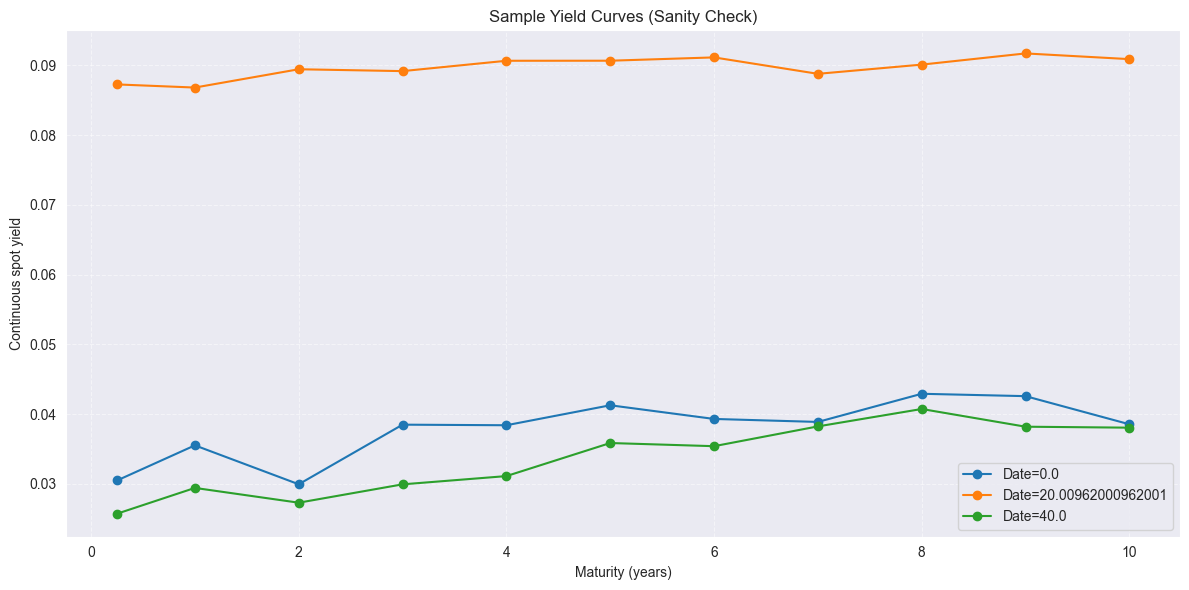

In [49]:
# maturities in years matching your columns
maturities = np.array([0.25] + list(range(1, 11)))  # 0.25,1,...,10

# choose some indices (first, middle, last)
idx_first = term_structure.index[0]
idx_middle = term_structure.index[len(term_structure)//2]
idx_last = term_structure.index[-1]

curve_dates = [idx_first, idx_middle, idx_last]

fig, ax = plt.subplots(figsize=(12,6))

for d in curve_dates:
    y = term_structure.loc[d, ["y_0_25"] + [f"y_{n}Y" for n in range(1, 11)]].values
    plt.plot(maturities, y, marker="o", label=f"Date={d}")

plt.xlabel("Maturity (years)")
plt.ylabel("Continuous spot yield")
plt.title("Sample Yield Curves (Sanity Check)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

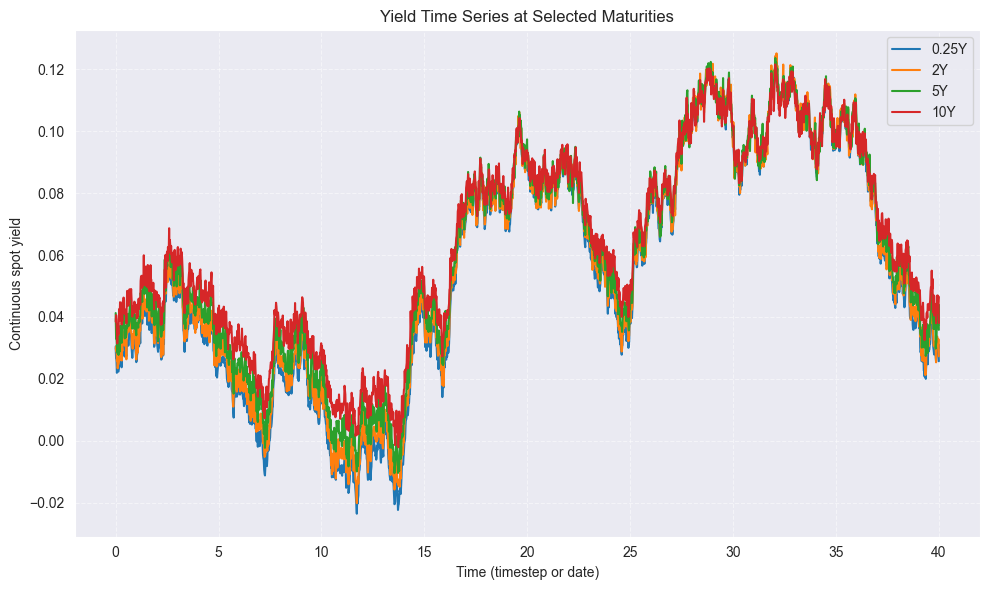

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

for col, label in [
    ("y_0_25", "0.25Y"),
    ("y_2Y",   "2Y"),
    ("y_5Y",   "5Y"),
    ("y_10Y",  "10Y")
]:
    plt.plot(term_structure.index, term_structure[col], label=label)

plt.xlabel("Time (timestep or date)")
plt.ylabel("Continuous spot yield")
plt.title("Yield Time Series at Selected Maturities")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [51]:
print(term_structure[["y_0_25", "y_2Y", "y_5Y", "y_10Y"]].describe())


            y_0_25         y_2Y         y_5Y        y_10Y
count  2080.000000  2080.000000  2080.000000  2080.000000
mean      0.054784     0.057215     0.060301     0.063727
std       0.037485     0.036255     0.034246     0.031100
min      -0.023481    -0.020079    -0.010399    -0.002054
25%       0.026523     0.030013     0.034718     0.040207
50%       0.052129     0.055035     0.058563     0.061741
75%       0.087009     0.088052     0.089813     0.090454
max       0.122540     0.125078     0.123561     0.121522
